In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Data for Korea from 1970 - 2020

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data = data.set_index('quarter')

In [4]:
data = np.log(data.astype(float))

In [5]:
cycle, trend = sm.tsa.filters.hpfilter(data.iloc[:,0],1600)

In [55]:
# Booking the moments of the data

cycle = np.zeros((118,8))
trend = np.zeros((118,8))
std = np.zeros(8)
relstd = np.zeros(8)
autocorr = np.zeros(8)
crosscorr = np.zeros((5,8))

for i in range(8):
    cycle[:,i], trend[:,i] = sm.tsa.filters.hpfilter(data.iloc[:,i],1600)
    std[i] = np.std(cycle[:,i])
    relstd[i] = np.std(cycle[:,i]) / np.std(cycle[:,0])
    autocorr[i] = np.correlate(cycle[0:117,i], cycle[1:118,i]) / ( (117 * np.var(cycle[0:117,i]) * 117 * np.var(cycle[1:118,i]))**0.5 )
    
    crosscorr[0, i] = np.correlate(cycle[0:116,0], cycle[2:118,i]) / ( (116 * np.var(cycle[0:116,0]) * 116 * np.var(cycle[2:118,i]))**0.5 )
    crosscorr[1, i] = np.correlate(cycle[0:117,0], cycle[1:118,i]) / ( (117 * np.var(cycle[0:117,0]) * 117 * np.var(cycle[1:118,i]))**0.5 )
    crosscorr[2, i] = np.correlate(cycle[0:118,0], cycle[0:118,i]) / ( (118 * np.var(cycle[0:118,0]) * 118 * np.var(cycle[0:118,i]))**0.5 )
    crosscorr[3, i] = np.correlate(cycle[1:118,0], cycle[0:117,i]) / ( (117 * np.var(cycle[1:118,0]) * 117 * np.var(cycle[0:117,i]))**0.5 )
    crosscorr[4, i] = np.correlate(cycle[2:118,0], cycle[0:116,i]) / ( (116 * np.var(cycle[2:118,0]) * 116 * np.var(cycle[0:116,i]))**0.5 )

# Model 1: Standard RBC with divisible labor

In [68]:
from sympy.functions.elementary.exponential import exp
from sympy.functions.elementary.exponential import log

# Assigning Parameteres
β = 0.99; θ = 0.36; δ = 0.025; ρ=0.95; σ = 0.007


# Defining the functions
def u(c,l, μ):
    return log(c) + μ * log(l)

def f(k, h, θ=θ):
    return (k**θ) * (h**(1-θ))

def c(z, k, h, kp, θ=θ):
    return exp(z)*f(k, h, θ) + (1-δ)*k - kp

In [69]:
from sympy import Symbol
from sympy import solve

k = Symbol('k') ; z = Symbol('z'); h = Symbol('h'); kp = Symbol('kp')

# Setting the Steady State Level

z_bar = 0; h_bar = 1/3


# Setting Euler Equations
EE1 = β * (exp(z_bar) * f(k,h).diff(k).subs({h:h_bar}) + 1 - δ ) -1
k_bar = float(solve(EE1, k)[0])

μ = Symbol('μ')
c_bar = c(z_bar, k_bar, h_bar, k_bar)

EE2 = (1 / c_bar) * exp(z_bar) * f(k, h).diff(h).subs({k:k_bar, h:h_bar}) - μ/(1-h_bar)
μ = float(solve(EE2, μ)[0])

# W vector of L-Q Approximation
W = np.array([[z], [k], [kp], [h]])
W_bar = np.array([[z_bar], [k_bar], [k_bar], [h_bar]])

In [70]:
# Deriving Jacobian and Hessian Matrix
r = u(c(z, k, h, kp), 1-h, μ)

Jac = np.zeros((np.size(W), 1))
for i in range(np.size(W)):
    r_i = r.diff(W.item(i))
    Jac[i] = r_i.subs({z:z_bar, k:k_bar, h:h_bar, kp:k_bar})
    
Hes = np.zeros((np.size(W), np.size(W)))
for i in range(np.size(W)):
    for j in range(np.size(W)):
        r_i = r.diff(W.item(i))
        r_ij = r_i.diff(W.item(j))
        Hes[i,j] = r_ij.subs({z:z_bar, k:k_bar, h:h_bar, kp:k_bar})

In [71]:
# Deriving Q Matrix of L-Q Apprximation
R_bar = float(u(c_bar, 1 - h_bar, μ))

q1 = R_bar - W_bar.T @ Jac + (W_bar.T @ Hes @ W_bar)/2
q3 = (Jac - Hes @ W_bar) / 2
q2 = q3.T
q4 = Hes / 2

Q1 = np.concatenate((q1, q2), axis = 1)
Q2 = np.concatenate((q3, q4), axis = 1)
Q = np.concatenate((Q1, Q2), axis = 0)
Q

array([[-1.63788047,  0.67240712,  1.10019708, -1.0891951 ,  1.93653251],
       [ 0.67240712, -0.23185555, -0.72066442,  0.73238254, -0.44516266],
       [ 1.10019708, -0.72066442, -0.60618293,  0.59916463, -1.38367569],
       [-1.0891951 ,  0.73238254,  0.59916463, -0.59317299,  1.40617448],
       [ 1.93653251, -0.44516266, -1.38367569,  1.40617448, -6.66430983]])

In [72]:
# Deriving M Matrix of L-Q Apprximation
P0 = np.eye(3)
B = np.array([[1, 0, 0, 0, 0],
             [0, ρ, 0, 0, 0],
             [0, 0, 0, 1, 0]])

M = B.T @ P0 @ B + np.array([[P0[1,1]*σ**2, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0]])

In [73]:
# Approximation Process

import timeit

count = 0
max_iter = 2000
tol = 1e-6
P0 = np.zeros((3,3))

start = timeit.default_timer()

while count < max_iter:
    M = ( B.T @ P0 @ B ) + np.array([[P0[1,1]*σ**2, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0]])
    
    QM = Q + β*M
    QMff = QM[:3, :3]; QMfd = QM[:3, 3:]; QMdd = QM[3:, 3:]
    P1 = QMff - (QMfd @ np.linalg.inv(QMdd) @ QMfd.T)
    
    if np.max(np.abs(P1 - P0)) < tol:
        print("The number of iteration is", count)
        break
        
    count += 1
    P0 = P1
        
stop = timeit.default_timer()

P_star = P1
print('P_star is', P_star)
print('The time costs', stop - start)


The number of iteration is 1397
P_star is [[-9.64067939e+01  1.36799985e+01  8.78360683e-01]
 [ 1.36799985e+01  4.31623423e+00 -1.87871958e-01]
 [ 8.78360683e-01 -1.87871958e-01 -2.59227636e-02]]
The time costs 0.06410112499906973


In [74]:
# Deriving the Optimal Decision Rule

M_star = B.T @ P_star @ B + np.array([[P_star[1,1]*σ**2, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0]])

QM_star = Q + β*M_star
QMff = QM_star[:3, :3]; QMfd = QM_star[:3, 3:]; QMdd = QM_star[3:, 3:]
F = np.array([1, z, k])
d = -np.dot(np.linalg.inv(QMdd) @ QMfd.T, F)
gk = d.item(0)
gh = d.item(1)
d

array([0.953669309096013*k + 1.43344468505707*z + 0.586689454449938,
       -0.00639979904277871*k + 0.235659914320878*z + 0.414374529476483],
      dtype=object)

# (1) Impulse Response

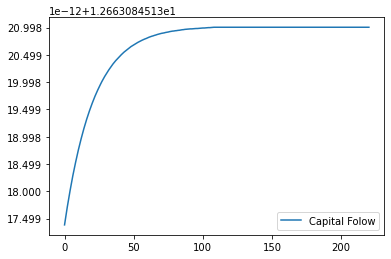

In [75]:
# Checking the Captial Steady State 

t_min = 0
t_max = 220
time = np.linspace(t_min, t_max-1 , t_max - t_min)

ks = []
ks.append(k_bar)
count = 0

for i in range(t_max):
    k1 = gk.subs({k:float(ks[i]), z:z_bar})
    ks.append(float(k1))
    count += 1
    
fig, ax = plt.subplots()
ax.plot(ks, label = 'Capital Folow')
ax.legend()

plt.show()

Text(0.5, 0, 't')

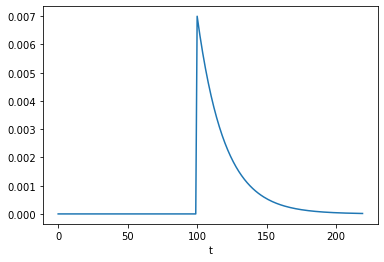

In [80]:
# TFP Shock's Impulse Response(Positive TFP Shock at t = 100)

z0 = z_bar
zs = []

t_min = 0
t_max = 220
time = np.linspace(t_min, t_max-1 , t_max - t_min)

for i in range(t_max):
    if i == 100:
        z1 = (1-ρ)*z_bar + ρ*z0 + σ
        zs.append(float(z1))
        z0 = z1
        
    else:
        z1 = (1-ρ)*z_bar + ρ*z0 
        zs.append(float(z1))
        z0 = z1
        
fig, ax = plt.subplots()
ax.plot(time, zs , label = '')
ax.set_xlabel('t')

Text(0.5, 0, 't')

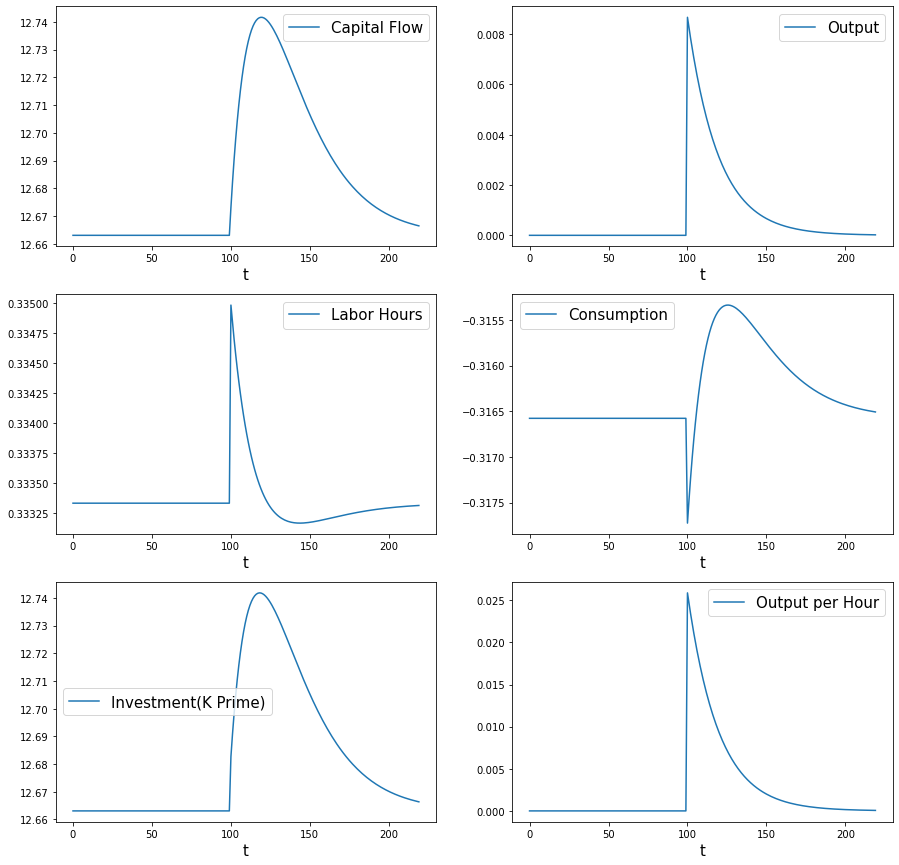

In [77]:
# Impuse Response for the Variables(Positive TFP Shock at t = 100)

ks = []
ys = []
hs = []
invs = []
yphs = []
cs = []

ks.append(k_bar)
count = 0

for i in range(t_max):
    k1 = float(gk.subs({k:ks[i], z:zs[i]}))
    h1 = float(gh.subs({k:ks[i], z:zs[i]}))
    ks.append(k1)
    hs.append(h1)
    y1 = zs[i] * f(k1, h1)
    ys.append(y1)
    invs1 = float(gk.subs({k:k1, z:zs[i]}))
    invs.append(invs1)
    c1 = y1 + (1-δ)*k1 - invs1
    cs.append(c1)
    yph = y1 / h1
    yphs.append(yph)
    
    count += 1
    
fig, ax = plt.subplots(3,2, figsize = (15, 15))
ax[0,0].plot(time, ks[1:], label = 'Capital Flow')
ax[0,0].legend(fontsize = 15)
ax[0,0].set_xlabel('t', fontsize = 15)
ax[0,1].plot(time, ys, label = 'Output')
ax[0,1].legend(fontsize = 15)
ax[0,1].set_xlabel('t', fontsize = 15)
ax[1,0].plot(time, hs, label = 'Labor Hours')
ax[1,0].legend(fontsize = 15)
ax[1,0].set_xlabel('t', fontsize = 15)
ax[1,1].plot(time, cs, label = 'Consumption')
ax[1,1].legend(fontsize = 15)
ax[1,1].set_xlabel('t', fontsize = 15)
ax[2,0].plot(time, invs, label = 'Investment(K Prime)')
ax[2,0].legend(fontsize = 15)
ax[2,0].set_xlabel('t', fontsize = 15)
ax[2,1].plot(time, yphs, label = 'Output per Hour')
ax[2,1].legend(fontsize = 15)
ax[2,1].set_xlabel('t', fontsize = 15)

# (2) Simulation

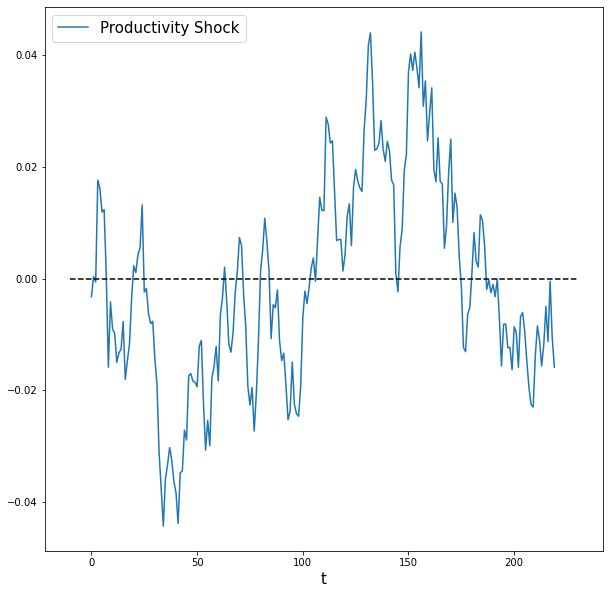

In [83]:
z0 = z_bar
zs = []

for i in range(t_max):
    z1 = ρ*z0 + σ*np.random.randn()
    zs.append(float(z1))
    z0 = z1
    
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(time, zs, label = 'Productivity Shock')
ax.hlines(y = 0, xmin = - 10, xmax = 230, colors ='k', linestyles = 'dashed')
ax.set_xlabel('t', fontsize = 15)
ax.legend(fontsize = 15)
plt.show()

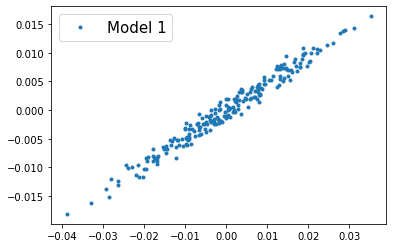

In [85]:
# Simulation and Replicating a Graph from Hansen and Wright(1992)

ks = []
ys = []
hs = []
invs =  []
yphs = []
cs = []

ks.append(k_bar)
count = 0
for i in range(t_max):
    k1 = float(gk.subs({k:ks[i],z:zs[i]}))
    h1 = float(gh.subs({k:ks[i],z:zs[i]}))
    ks.append(k1)
    hs.append(h1)
    y1 = float(exp(zs[i]) * f(k1,h1))
    ys.append(y1)
    inv1 = float(gk.subs({k:k1,z:zs[i]}))
    invs.append(inv1)
    c1 = y1 + (1-δ)*k1 - inv1
    cs.append(c1)
    yph = y1/h1
    yphs.append(yph)
    count += 1

lnks = []
lnhs = []
lnys = []
lncs = []
lninvs = []
lnyphs = [] 
for i in range(t_max):
    lnks.append(np.log(ks[i]))
    lnhs.append(np.log(hs[i]))
    lnys.append(np.log(ys[i]))
    lncs.append(np.log(cs[i]))
    lninvs.append(np.log(invs[i]))
    lnyphs.append(np.log(yphs[i]))
    
label = ['lnks','lnhs','lnys','lncs','lninvs','lnyphs']
sdmdf = pd.DataFrame({'lnks':lnks,'lnhs':lnhs,'lnys':lnys,'lncs':lncs,'lninvs':lninvs,'lnyphs':lnyphs})

cycle, trend = sm.tsa.filters.hpfilter(sdmdf.iloc[:,2],1600)
sdmdf_cycle_lnys = cycle
cycle, trend = sm.tsa.filters.hpfilter(sdmdf.iloc[:,1],1600)
sdmdf_cycle_lnhs = cycle

figure, ax = plt.subplots()

plt.plot(sdmdf_cycle_lnys,sdmdf_cycle_lnhs,'.',label = 'Model 1')
plt.legend(fontsize = 15)

plt.show()

# (3) Model Generated Standard Deviation

In [52]:
lnks_cycle = []
lnys_cycle = []
lnhs_cycle = []
lninvs_cycle = []
lnyphs_cycle = []
lncs_cycle = []

for j in range(100):
    zs = []
    ks = [] ; ys = [] ; hs = [] ; invs =  []; yphs = [] ;cs = []
    lnks = [] ; lnhs = [] ; lnys = [] ; lncs = [] ; lninvs = [] ; lnyphs = [] 
    
    tmin = 0 ; tmax = 240 ; time = np.linspace(tmin,tmax-1,tmax-tmin)
    
    for i in range(tmax):
        z1 = (1-ρ)*z_bar + ρ*z0 + σ*np.random.randn()
        zs.append(float(z1))
        z0 = z1

    ks.append(k_bar)
    for i in range(tmax):
        k1 = float(gk.subs({k:ks[i],z:zs[i]}))
        h1 = float(gh.subs({k:ks[i],z:zs[i]}))
        ks.append(k1)
        hs.append(h1)
        y1 = float(exp(zs[i]) * f(k1,h1))
        ys.append(y1)
        inv1 = float(gk.subs({k:k1,z:zs[i]}))
        invs.append(inv1)
        c1 = y1 + (1-δ)*k1 - inv1
        cs.append(c1)
        yph = y1/h1
        yphs.append(yph)

    for i in range(tmax):
        lnks.append(np.log(ks[i]))
        lnhs.append(np.log(hs[i]))
        lnys.append(np.log(ys[i]))
        lncs.append(np.log(cs[i]))
        lninvs.append(np.log(invs[i]))
        lnyphs.append(np.log(yphs[i]))

    lndf = pd.DataFrame({'lnks':lnks,'lnhs':lnhs,'lnys':lnys,'lncs':lncs,'lninvs':lninvs,'lnyphs':lnyphs})
    
    cycle, trend = sm.tsa.filters.hpfilter(lndf.iloc[:,0],1600)
    lnks_cycle.append(cycle.std())
    
    cycle, trend = sm.tsa.filters.hpfilter(lndf.iloc[:,1],1600)
    lnhs_cycle.append(cycle.std())
    
    cycle, trend = sm.tsa.filters.hpfilter(lndf.iloc[:,2],1600)
    lnys_cycle.append(cycle.std())
    
    cycle, trend = sm.tsa.filters.hpfilter(lndf.iloc[:,3],1600)
    lncs_cycle.append(cycle.std())
    
    cycle, trend = sm.tsa.filters.hpfilter(lndf.iloc[:,4],1600)
    lninvs_cycle.append(cycle.std())
    
    cycle, trend = sm.tsa.filters.hpfilter(lndf.iloc[:,5],1600)
    lnyphs_cycle.append(cycle.std())

In [86]:
# Calculating the model generated standard deviation

np.mean(lnks_cycle), np.mean(lnhs_cycle), np.mean(lnys_cycle), np.mean(lncs_cycle), np.mean(lninvs_cycle), np.mean(lnyphs_cycle)

(0.003538417062770933,
 0.006382488457318758,
 0.013399009372918555,
 0.004735369971225156,
 0.0037991448260808807,
 0.00722291590195128)